OpenAI의 Assistants API와 Code Interpreter를 활용하여, 확률 개념을 설명하고 시각화할 수 있는 챗봇을 구현합니다.

## 구현 목표
- 대학교 1학년 수준의 확률 개념을 자연어로 설명
- 간단한 확률 문제를 코드로 해결
- 그래프 등 시각화를 자동 생성
- 사용자의 질문 흐름을 기억하고 이어서 답변
- 대화형 챗봇처럼 자연스러운 인터페이스 구성
- 사용자 수준(초심자, 전공자)에 따른 설명 톤 조절

## 필수 구현 기능
- Assistant 생성 시 Code Interpreter 도구 포함
- 사용자 입력을 받아 Thread 내 대화 유지
- 문제 해결을 위한 파이썬 코드 자동 실행
- 시각화 결과를 이미지로 생성하여 출력
- 이미지 자동 표시

In [1]:
# 필요한 라이브러리 import
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from datetime import datetime
import warnings
import sys
from pathlib import Path
from dotenv import load_dotenv
from openai import OpenAI
import os

warnings.filterwarnings('ignore')

# 한글 폰트 설정 (macOS 기준)
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False

# matplotlib 출력 설정
# plt.rcParams['figure.max_open_warning'] = 0
# matplotlib.rcParams['figure.max_open_warning'] = 0


ROOT_DIR = Path.cwd()
sys.path.append(str(ROOT_DIR))

ENV_PATH = ROOT_DIR / ".env"

if ENV_PATH.exists():
    load_dotenv(ENV_PATH)
    print(f".env 파일을 로드했습니다: {ENV_PATH}")
else:
    # .env 파일이 없으면 기본값 사용
    print(".env 파일이 없습니다. 기본 설정값을 사용합니다.")

# OpenAI API 키 설정
api_key = os.getenv("OPENAI_API_KEY")
client = OpenAI(api_key=api_key)  # OR 직접 입력

print("✅ 라이브러리 로드 완료")

.env 파일을 로드했습니다: /Users/tykim/Desktop/work/SNU_bigdata_fintech_2025/ai-application-assignment/.env
✅ 라이브러리 로드 완료


In [2]:
# ProbTutor Assistant 클래스 정의
class ProbTutor:
    def __init__(self, api_key=None):
        """
        확률 개념을 설명하고 시각화할 수 있는 챗봇 초기화
        """
        if api_key:
            client.api_key = api_key

        # Assistant 생성 (Code Interpreter 포함)
        self.assistant = client.beta.assistants.create(
            name="ProbTutor",
            instructions="""
            당신은 대학교 1학년 학생들을 위한 확률론 튜터입니다.
            
            주요 역할:
            1. 대학교 1학년 수준의 확률 개념을 쉽고 명확하게 설명
            2. 기본적인 확률 문제를 단계별로 해결
            3. 시각화를 통한 직관적 이해 도움
            4. 수학적 공식과 직관적 설명의 균형
            
            다루는 확률론 영역 (대학교 1학년 수준):
            - 기본 확률: 표본공간, 사건, 확률의 기본 성질
            - 조건부 확률과 독립성
            - 베이즈 정리와 베이지안 추론
            - 확률변수와 확률분포 (이산/연속)
            - 기댓값, 분산, 공분산, 상관계수
            - 주요 확률분포: 이항분포, 정규분포, 포아송분포, 지수분포 등
            - 중심극한정리와 대수의 법칙
            - 가설검정과 신뢰구간
            - 회귀분석과 상관분석
            - 마르코프 체인과 확률과정
            - 기본적인 통계 개념
            
            설명 원칙:
            - 대학교 1학년 수준에 맞는 설명
            - 친근하고 이해하기 쉬운 언어 사용
            - 구체적인 예시와 비유 활용
            - 단계별 설명으로 복잡한 개념 분해
            - 시각적 자료를 적극 활용
            - 수학 공식과 함께 직관적인 설명 제공
            
            시각화 가이드라인:
            - 파이 차트: 구성 비율 표시
            - 막대 그래프: 빈도나 확률 비교
            - 히스토그램: 분포 시각화
            - 산점도: 상관관계 표시
            - 조건부 확률: 벤 다이어그램, 트리 다이어그램
            
            응답 형식:
            1. 개념의 직관적 설명
            2. 수학적 공식 제시 (간단한 수준)
            3. 구체적인 예시와 계산 과정
            4. Python 코드로 구현 및 시각화
            5. 실생활 응용사례
            6. 핵심 포인트 정리
            
            코드 작성 원칙:
            - numpy, matplotlib 기본 활용
            - 주석이 포함된 명확한 코드
            - 시각화는 반드시 포함
            - 수치적 결과와 해석 제공
            """,
            model="gpt-4",
            tools=[{"type": "code_interpreter"}],
        )

        # 대화 기록 저장
        self.conversation_history = []
        self.user_level = "college_freshman"  # 대학교 1학년으로 고정

        print(f"ProbTutor Assistant 생성 완료! (ID: {self.assistant.id})")

    def create_thread(self):
        """새로운 대화 스레드 생성"""
        self.thread = client.beta.threads.create()
        print("새로운 대화 스레드가 생성되었습니다.")
        return self.thread.id

    def detect_user_level(self, message):
        """사용자 수준은 대학교 1학년으로 고정"""
        # 대학교 1학년 수준으로 고정
        self.user_level = "college_freshman"
        return self.user_level

    def send_message(self, message):
        """사용자 메시지를 Assistant에게 전송하고 응답 받기"""
        # 사용자 입력 로그
        print(f"\n👤 사용자 입력: {message}")

        print("\n🤖 ProbTutor가 답변을 준비하고 있습니다...")

        # 사용자 수준 감지
        self.detect_user_level(message)

        # 메시지를 스레드에 추가
        client.beta.threads.messages.create(
            thread_id=self.thread.id,
            role="user",
            content=message
        )

        # Assistant 실행
        run = client.beta.threads.runs.create(
            thread_id=self.thread.id,
            assistant_id=self.assistant.id
        )

        # 실행 완료까지 대기
        while run.status in ['queued', 'in_progress', 'cancelling']:
            run = client.beta.threads.runs.retrieve(
                thread_id=self.thread.id,
                run_id=run.id
            )

        if run.status == 'completed':
            # 응답 메시지 가져오기
            messages = client.beta.threads.messages.list(
                thread_id=self.thread.id
            )

            # 최신 응답 메시지
            latest_message = messages.data[0]

            # 응답 내용 처리 (텍스트와 이미지 모두 처리)
            response_text = ""
            image_files = []

            for content in latest_message.content:
                if hasattr(content, 'text') and content.text:
                    response_text += content.text.value + "\n"
                elif hasattr(content, 'image_file'):
                    # 이미지 파일 처리
                    image_file_id = content.image_file.file_id
                    image_files.append(image_file_id)

            # 이미지가 있으면 다운로드 및 표시
            if image_files:
                self.display_images(image_files)

            # 대화 기록에 저장
            self.conversation_history.append({
                'user': message,
                'assistant': response_text,
                'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'user_level': self.user_level,
                'images': image_files
            })

            return response_text
        else:
            return f"오류가 발생했습니다: {run.status}"

    def get_conversation_history(self):
        """대화 기록 반환"""
        return self.conversation_history

    def display_images(self, image_file_ids):
        """이미지 파일들을 다운로드하고 표시"""
        for file_id in image_file_ids:
            try:
                # 이미지 파일 다운로드
                image_data = client.files.content(file_id)
                image_bytes = image_data.read()

                # 이미지 표시
                from IPython.display import Image, display
                display(Image(data=image_bytes))

            except Exception as e:
                print(f"❌ 이미지 표시 중 오류 발생: {e}")

    def reset_conversation(self):
        """대화 초기화"""
        self.conversation_history = []
        self.user_level = "college_freshman"
        self.create_thread()
        print("대화가 초기화되었습니다.")

# ProbTutor 인스턴스 생성
try:
    prob_tutor = ProbTutor()
    prob_tutor.create_thread()
    print("ProbTutor가 성공적으로 초기화되었습니다!")
except Exception as e:
    print(f"ProbTutor 초기화 중 오류 발생: {e}")
    print("OPEN AI API 키가 올바르게 설정되었는지 확인해주세요.")

ProbTutor Assistant 생성 완료! (ID: asst_5n317jJIthH4st2vJdgT1YpO)
새로운 대화 스레드가 생성되었습니다.
ProbTutor가 성공적으로 초기화되었습니다!


In [3]:
# 대화형 챗봇 인터페이스 구현
class ChatInterface:
    def __init__(self, prob_tutor):
        self.prob_tutor = prob_tutor
        self.is_running = True

    def display_welcome(self):
        """환영 메시지 표시"""
        welcome_msg = """
        🎲 ProbTutor에 오신 것을 환영합니다! 🎲
        
        저는 확률 개념을 쉽게 설명하고 시각화해드리는 AI 튜터입니다.
        
        주요 기능:
        • 확률 개념 설명 및 문제 해결
        • 자동 시각화 (그래프, 차트 등)
        • 사용자 수준에 맞는 설명
        • 대화 흐름 기억 및 이어서 답변
        
        사용법:
        • 질문을 입력하세요
        • 'exit' 또는 'quit'를 입력하면 종료됩니다
        • 'reset'을 입력하면 대화를 초기화합니다
        • 'history'를 입력하면 대화 기록을 볼 수 있습니다
        
        예시 질문:
        - "간단한 조건부 확률 문제를 만들어줘"
        - "주사위 확률을 시각화해줘"
        - "베이즈 정리를 설명해줘"
        """
        print(welcome_msg)

    def format_response(self, response):
        """응답을 포맷팅"""
        print("\n🤖 ProbTutor:")
        print(response + '\n')

    def log_conversation(self, user_input, assistant_response):
        """대화를 로그에 기록"""
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"\n📝 [{timestamp}] 대화 로그:")
        print(f"\n👤 사용자: {user_input}")
        print(f"\n🤖 ProbTutor: {assistant_response[:100]}{'...' if len(assistant_response) > 100 else ''}")
        print("-" * 50)

    def display_history(self):
        """대화 기록 표시"""
        history = self.prob_tutor.get_conversation_history()
        if not history:
            print("아직 대화 기록이 없습니다.")
            return

        print("\n📚 대화 기록:")
        print("-" * 50)
        for i, conv in enumerate(history, 1):
            print(f"\n[{i}] {conv['timestamp']} (수준: {conv['user_level']})")
            print(f"\n👤 사용자: {conv['user']}")
            print(f"\n🤖 ProbTutor: {conv['assistant'][:200]}...")
        print("-" * 50 + "\n")

    def run(self):
        """챗봇 실행"""
        self.display_welcome()

        while self.is_running:
            try:
                # 사용자 입력 받기
                user_input = input("👤 당신: ").strip()

                # 종료 명령어 처리
                if user_input.lower() in ['exit', 'quit', '종료']:
                    print("👋 ProbTutor를 이용해주셔서 감사합니다!")
                    self.is_running = False
                    break

                # 대화 초기화
                elif user_input.lower() in ['reset', '초기화']:
                    self.prob_tutor.reset_conversation()
                    continue

                # 대화 기록 보기
                elif user_input.lower() in ['history', '기록']:
                    self.display_history()
                    continue

                # 빈 입력 처리
                elif not user_input:
                    print("질문을 입력해주세요!")
                    continue

                # ProbTutor에게 메시지 전송 및 응답 받기
                response = self.prob_tutor.send_message(user_input)

                # 응답 표시
                self.format_response(response)

            except KeyboardInterrupt:
                print("\n\n👋 ProbTutor를 이용해주셔서 감사합니다!")
                self.is_running = False
                break
            except Exception as e:
                print(f"❌ 오류가 발생했습니다: {e}")
                print("다시 시도해주세요.")

# 챗봇 인터페이스 생성
chat_interface = ChatInterface(prob_tutor)

In [4]:
# 확률 계산 및 시각화 함수들
class ProbabilityVisualizer:
    def __init__(self):
        self.colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']

    def create_pie_chart(self, labels, sizes, title="확률 분포", explode=None):
        """파이 차트 생성"""
        plt.figure(figsize=(10, 8))

        if explode is None:
            explode = [0.05] * len(labels)  # 약간의 분리 효과

        wedges, texts, autotexts = plt.pie(sizes, 
                                         labels=labels, 
                                         autopct='%1.1f%%',
                                         explode=explode,
                                         colors=self.colors[:len(labels)],
                                         shadow=True,
                                         startangle=90)

        # 텍스트 스타일링
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(12)

        plt.title(title, fontsize=16, fontweight='bold', pad=20)
        plt.axis('equal')
        plt.tight_layout()
        # display(plt.gcf())
        plt.show()
        # plt.close()

    def create_bar_chart(self, categories, values, title="확률 비교", ylabel="확률"):
        """막대 그래프 생성"""
        plt.figure(figsize=(12, 6))
        bars = plt.bar(categories, values, color=self.colors[:len(categories)])

        # 값 표시
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

        plt.title(title, fontsize=16, fontweight='bold')
        plt.ylabel(ylabel, fontsize=12)
        plt.xlabel("카테고리", fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        # plt.close()

    def create_histogram(self, data, bins=10, title="확률 분포 히스토그램"):
        """히스토그램 생성"""
        plt.figure(figsize=(10, 6))
        plt.hist(data, bins=bins, color=self.colors[0], alpha=0.7, edgecolor='black')
        plt.title(title, fontsize=16, fontweight='bold')
        plt.xlabel("값", fontsize=12)
        plt.ylabel("빈도", fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        # display(plt.gcf())
        plt.show()
        # plt.close()

# 확률 시각화 도구 생성
prob_viz = ProbabilityVisualizer()

In [5]:
def start_chatbot():
    """챗봇 시작"""
    try:
        chat_interface.run()
    except Exception as e:
        print(f"챗봇 실행 중 오류 발생: {e}")
        print("OpenAI API 키가 올바르게 설정되었는지 확인해주세요.")


In [6]:
# 실제 사용 예시 및 테스트
print("🚀 ProbTutor 구현 완료!")
print("="*50)

print("\n💡 예시 질문들:")
example_questions = [
    "간단한 조건부 확률 문제를 만들어줘",
    "주사위 확률을 시각화해줘", 
    "베이즈 정리를 설명해줘",
    "동전 던지기 시뮬레이션을 보여줘",
    "카드 게임 확률을 계산해줘",
    "확률 분포를 그래프로 그려줘"
]

for i, question in enumerate(example_questions, 1):
    print(f"   {i}. \"{question}\"")

print("\n🔧 추가 기능:")
print("• 'exit' 또는 'quit': 챗봇 종료")
print("• 'reset' 또는 '초기화': 대화 초기화") 
print("• 'history' 또는 '기록': 대화 기록 보기")

print("\n" + "="*50)
print("ProbTutor가 준비되었습니다! 🎲")


🚀 ProbTutor 구현 완료!

💡 예시 질문들:
   1. "간단한 조건부 확률 문제를 만들어줘"
   2. "주사위 확률을 시각화해줘"
   3. "베이즈 정리를 설명해줘"
   4. "동전 던지기 시뮬레이션을 보여줘"
   5. "카드 게임 확률을 계산해줘"
   6. "확률 분포를 그래프로 그려줘"

🔧 추가 기능:
• 'exit' 또는 'quit': 챗봇 종료
• 'reset' 또는 '초기화': 대화 초기화
• 'history' 또는 '기록': 대화 기록 보기

ProbTutor가 준비되었습니다! 🎲



        🎲 ProbTutor에 오신 것을 환영합니다! 🎲

        저는 확률 개념을 쉽게 설명하고 시각화해드리는 AI 튜터입니다.

        주요 기능:
        • 확률 개념 설명 및 문제 해결
        • 자동 시각화 (그래프, 차트 등)
        • 사용자 수준에 맞는 설명
        • 대화 흐름 기억 및 이어서 답변

        사용법:
        • 질문을 입력하세요
        • 'exit' 또는 'quit'를 입력하면 종료됩니다
        • 'reset'을 입력하면 대화를 초기화합니다
        • 'history'를 입력하면 대화 기록을 볼 수 있습니다

        예시 질문:
        - "간단한 조건부 확률 문제를 만들어줘"
        - "주사위 확률을 시각화해줘"
        - "베이즈 정리를 설명해줘"
        

👤 사용자 입력: 베이즈 정리를 알려줘

🤖 ProbTutor가 답변을 준비하고 있습니다...

🤖 ProbTutor:
베이즈 정리는 조건부 확률에 대한 중요한 이론입니다. '사전' 정보가 주어졌을 때, 새로운 정보를 어떻게 통합하고, 그 기반으로 '사후' 확률을 어떻게 업데이트할지를 설명해주는 정리입니다.

대학에서 베이즈 정리는 보통 다음과 같은 수학적 형식으로 제시됩니다.

    P(A|B) = ( P(B|A) * P(A) ) / P(B)

이 수식을 자세히 나눠 설명해보겠습니다:
- P(A|B) : B가 일어났을 때 A가 일어날 조건부 확률입니다. 이것은 우리가 새로운 정보 B를 얻었을 때, A가 일어날 확률을 업데이트하는 데 사용됩니다. 이를 '사후 확률'이라고 부르기도 합니다.
- P(B|A) : A가 일어났을 때 B가 일어날 조건부 확률입니다. 이것은 '사전'에 알고 있던 정보에 기반한 확률입니다.
- P(A) : A가 일어날 확률입니다. 이것은 '사전 확률'이라고 부릅니다.
- P(B) : B가 일어날 확률입니다. B가 일어날 

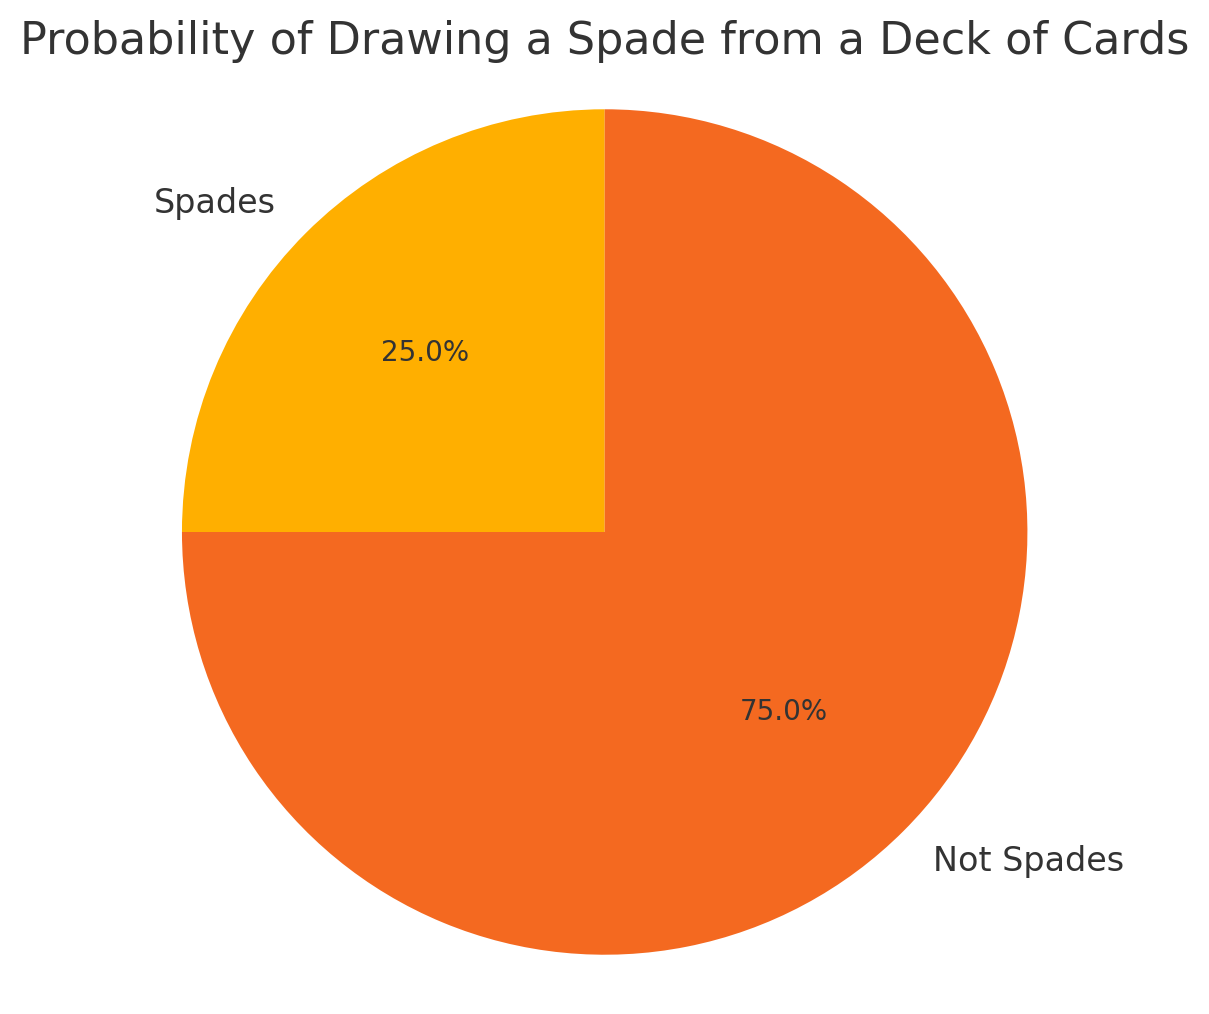


🤖 ProbTutor:
위의 파이 차트는 표준 카드 덱에서 스페이드 카드를 뽑을 확률을 시각화한 것입니다.

각 슬라이스는 다음과 같이 해석할 수 있습니다:

1. 'Spades' : 이 슬라이스는 스페이드 카드를 뽑을 확률을 나타냅니다. 표준 카드 덱에는 52장의 카드가 있고, 그 중 13장이 스페이드 카드이므로 확률은 13/52, 즉 약 25%입니다.

2. 'Not Spades' : 이 슬라이스는 스페이드 카드 이외의 카드를 뽑을 확률을 나타냅니다. 이는 1 - 스페이드 카드의 확률로 계산되어, 약 75%입니다.

이로서 확률론에서 기본적인 개념인 '표본공간'과 '사건'을 이해하고, 이를 통해 사건의 확률을 계산하고 시각화할 수 있었습니다. '표본공간'은 모든 가능한 결과의 집합(여기서는 52장의 카드 전체)이고, '사건'은 특정 결과의 집합(여기서는 13장의 스페이드 카드)을 의미합니다. 사건의 확률은 '사건의 횟수 / 표본공간의 횟수'로 계산됩니다.



👤 사용자 입력: 기댓값, 분산에  대해 설명해줘

🤖 ProbTutor가 답변을 준비하고 있습니다...

🤖 ProbTutor:
**기댓값(Expected Value)** 은 확률변수의 중심을 나타냅니다. 다른 말로 통계적 평균이라고도 합니다. 

이산 확률변수 X의 경우, 기댓값 E(X)는 각 가능한 값 x에 그 값을 취할 확률 P(X=x)를 곱한 값들을 모두 더한 것입니다. 수학적으로 표현하면 E(X) = ∑xP(X=x) 입니다.

**분산(Variance)** 은 확률변수의 산포도를 나타냅니다. 데이터가 얼마나 퍼져있는지를 측정하는 값입니다.

이산 확률변수 X의 경우, 분산 Var(X)는 각 가능한 값 x에서 기댓값 E(X)을 뺀 후 제곱하여, 그값에 확률 P(X=x)을 곱한 값들을 모두 더한 것입니다. 수학적으로 표현하면 Var(X) = ∑[ (x-E(X))^2 * P(X=x) ] 입니다.

**표준편차(Standard Deviation)**는 분산의 제곱근입니다. 분산과 같은 개념이지만

In [7]:
start_chatbot()